<a href="https://colab.research.google.com/github/ashahdeen/MAIZE-CROP-DISEASE-IMAGE-CLASSIFICATION/blob/dev-branch/maize_classification_inceptionV3_tr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#keras libraries
import keras


#libraries for loading images
from pathlib import Path
import pathlib
import PIL
import PIL.Image

import cv2


###Loading the dataset.

In [ ]:
#path to get document from drive.
p = Path("/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images") 

# downloading our dataset

data_dir= pathlib.Path(p)
data_dir

PosixPath('/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images')

###Checking our Dataset

###Data Preprocessing.


In [ ]:
train_path = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
valid_path = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'
test_path = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'

In [ ]:
#Preprocessing the data for InceptionV3 architecture

#Train data
# train_batches = ImageDataGenerator(preprocessing_function= tf.keras.preprocessing.image_dataset_from_directory(
#     directory=train_path, image_size=(224,224), batch_size=10))

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  image_size=(224,224),
  batch_size=32)

#Validation data
# valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.preprocessing.image_dataset_from_directory(
#     directory=valid_path, image_size=(224,224), batch_size=10))
#validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_path,
  image_size=(224,224),
  batch_size=32)

# #Test data
# test_batches = ImageDataGenerator(preprocessing_function= tf.keras.preprocessing.image_dataset_from_directory(
#     directory=test_path, image_size=(224,224), batch_size=10, shuffle=False))

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  image_size=(224,224),
  batch_size=32)

Found 3000 files belonging to 6 classes.
Found 660 files belonging to 6 classes.
Found 180 files belonging to 6 classes.


In [ ]:
#creating data and resizing our images
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
# Class name attributes on our dataset
class_names = train_ds.class_names
print(class_names)

['Blight', 'Common_rust', 'Gray Leaf Spot', 'SMUT500', 'healthy', 'maizestreak_aug']


In [ ]:
class_names = test_ds.class_names
print(class_names)

['Blight', 'Common_rust', 'Gray Leaf Spot', 'SMUT500', 'healthy', 'maizestreak_aug']


In [ ]:
# Iterating over our dataset to retrieve images
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
#catcheing our data so that it can be saved to our first epoch.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers

In [ ]:
# #normalizing from RBG of range[0,255] to range [0,1] to make it ideal for neural network 
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# #first_image = image_batch[0]
# # # Notice the pixels values are now in `[0,1]`.
# # print(np.min(first_image), np.max(first_image))

###Wandb

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Inception-v3 is a convolutional neural network architecture from the Inception family that makes several improvements including using Label Smoothing, Factorized 7 x 7 convolutions, and the use of an auxiliary classifer to propagate label information lower down the network (along with the use of batch normalization for layers in the sidehead)

Inception V3 by Google is the 3rd version in a series of Deep Learning Convolutional Architectures. Inception V3 was trained using a dataset of 1,000 classes (See the list of classes here) from the original ImageNet dataset which was trained with over 1 million training images, the Tensorflow version has 1,001 classes which is due to an additional "background' class not used in the original ImageNet. Inception V3 was trained for the ImageNet Large Visual Recognition Challenge where it was a first runner up.

###Transfer Learning Model 2: InceptionV3 Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Set seed to ensure the results remain the same
tf.random.set_seed(1000)

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#freezing of the layers.
for layer in base_model.layers:
    layer.trainable = False

#Initialize wandb with your project name
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.01,
                     "epochs": 20,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "maize_diseases_images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# # Initialize model like you usually do.
# tf.keras.backend.clear_session()
# model = Model()
# model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

import wandb
from wandb.keras import WandbCallback

# train the model on the new data for a few epochs
history = model.fit(
    train_ds,
    epochs=config.epochs, 
    batch_size=config.batch_size,
    validation_data=(val_ds),
    callbacks=[WandbCallback()])

# Add in a Jupyter notebook to indicate the run has finished
wandb.finish()

wandb: Currently logged in as: mo_g (use `wandb login --relogin` to force relogin)


Epoch 1/20
94/94 [==============================] - 636s 4s/step - loss: 121.5335 - acc: 0.3383 - val_loss: 1.6866 - val_acc: 0.4561
Epoch 2/20
94/94 [==============================] - 372s 4s/step - loss: 1.5121 - acc: 0.4347 - val_loss: 1.2850 - val_acc: 0.4879
Epoch 3/20
94/94 [==============================] - 370s 4s/step - loss: 1.2661 - acc: 0.4843 - val_loss: 1.2156 - val_acc: 0.4833
Epoch 4/20
94/94 [==============================] - 368s 4s/step - loss: 1.1644 - acc: 0.5117 - val_loss: 1.0929 - val_acc: 0.5364
Epoch 5/20
94/94 [==============================] - 367s 4s/step - loss: 1.0688 - acc: 0.5380 - val_loss: 1.0250 - val_acc: 0.5561
Epoch 6/20
94/94 [==============================] - 365s 4s/step - loss: 1.0574 - acc: 0.5657 - val_loss: 1.2748 - val_acc: 0.4894
Epoch 7/20
94/94 [==============================] - 365s 4s/step - loss: 1.0462 - acc: 0.5513 - val_loss: 1.0249 - val_acc: 0.5773
Epoch 8/20
94/94 [==============================] - 366s 4s/step - loss: 1.0186 -

acc,0.59933
best_epoch,14
best_val_loss,0.97877
epoch,19
loss,0.94127
val_acc,0.5697
val_loss,1.03419


acc,▁▃▅▅▆▇▆▇▇▇▇▇▇▆▇██▇█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▄▅▂▆▆▇▆▆▆▇▃▇▇▅▅█▆
val_loss,█▄▃▂▁▄▁▁▁▁▃▁▂▃▁▂▂▂▂▂


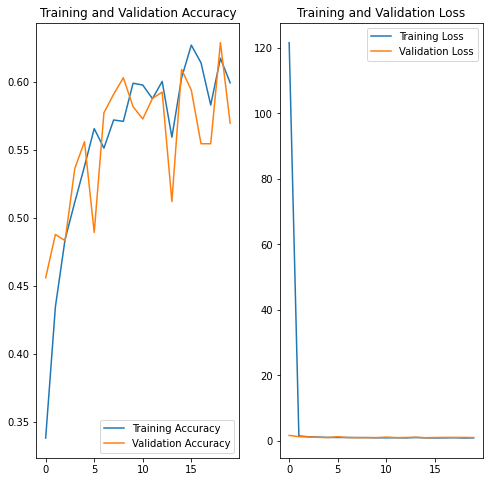

In [ ]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Saving the model
import tensorflow as tf
from keras.models import load_model
model.save('Inception_V3_Epoch_20')

INFO:tensorflow:Assets written to: Inception_V3_Epoch_20/assets


In [ ]:
Y_pred = model.predict_generator(test_ds)
y_pred = np.argmax(Y_pred, axis=1)
import tensorflow as tf
predicted_categories  = y_pred#= np.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

predicted_categories
true_categories = tf.concat([y for x, y in test_ds], axis=0)

classification_report = classification_report(predicted_categories, true_categories)
wandb.log({'classification_report': classification_report})
print(classification_report)

              precision    recall  f1-score   support

           0       0.17      0.20      0.18        25
           1       0.53      0.84      0.65        19
           2       0.87      0.41      0.55        64
           3       0.90      0.66      0.76        41
           4       0.67      0.95      0.78        21
           5       0.17      0.50      0.25        10

    accuracy                           0.55       180
   macro avg       0.55      0.59      0.53       180
weighted avg       0.68      0.55      0.57       180



In [ ]:
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

confusion_matrix = confusion_matrix(predicted_categories, true_categories)
wandb.log({'confusion_matrix': confusion_matrix})
print(confusion_matrix)

classification_report,precis...


[[ 5  5  3  0  5  7]
 [ 1 16  0  0  2  0]
 [20  5 26  1  3  9]
 [ 3  2  0 27  0  9]
 [ 0  1  0  0 20  0]
 [ 1  1  1  2  0  5]]


In [ ]:
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')
history = model.evaluate(test_ds, callbacks=[WandbCallback()])

wandb.log({'history' :history})

wandb.finish()

6/6 [==============================] - 19s 3s/step - loss: 1.1451 - acc: 0.5500


In [ ]:
history

[1.14506995677948, 0.550000011920929]

In [ ]:
# test_ds = test_ds.class_names
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

predictions = model.predict(x=test_ds, steps=len(test_ds), verbose=0, callbacks=[WandbCallback()])
wandb.log({'predictions' :predictions})

wandb.finish()


### Reducing epochs to 10 from 20 and learning rate to 0.001 from 0.01

In [ ]:
tf.random.set_seed(1000)

In [ ]:
#creating data and resizing our images
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import wandb
from wandb.keras import WandbCallback

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model1 = Model(inputs=base_model.input, outputs=predictions)

#freezing of the layers.
for layer in base_model.layers:
    layer.trainable = False

#Initialize wandb with your project name
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 10,
                     "batch_size": 32,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "InceptionV3",
                     "dataset": "maize_diseases_images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model1.compile(optimizer, config.loss_function, metrics=['acc'])

history = model1.fit(train_ds,
                    #val_ds,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    validation_data=(val_ds),
                    # Use the WandbCallback to automatically save all the metrics tracked in model.fit() to your dashboard
                    callbacks=[WandbCallback()])

# Add in a Jupyter notebook to indicate the run has finished
wandb.finish()

Epoch 1/10
94/94 [==============================] - 474s 1s/step - loss: 3.0109 - acc: 0.3160 - val_loss: 1.6536 - val_acc: 0.3303
Epoch 2/10
94/94 [==============================] - 18s 189ms/step - loss: 1.5327 - acc: 0.3757 - val_loss: 1.4809 - val_acc: 0.4606
Epoch 3/10
94/94 [==============================] - 18s 188ms/step - loss: 1.4342 - acc: 0.4403 - val_loss: 1.4168 - val_acc: 0.4758
Epoch 4/10
94/94 [==============================] - 18s 189ms/step - loss: 1.3066 - acc: 0.4863 - val_loss: 1.3029 - val_acc: 0.4758
Epoch 5/10
94/94 [==============================] - 18s 189ms/step - loss: 1.2084 - acc: 0.5100 - val_loss: 1.2401 - val_acc: 0.5182
Epoch 6/10
94/94 [==============================] - 18s 190ms/step - loss: 1.1824 - acc: 0.5237 - val_loss: 1.2547 - val_acc: 0.4939
Epoch 7/10
94/94 [==============================] - 18s 189ms/step - loss: 1.1366 - acc: 0.5243 - val_loss: 1.1181 - val_acc: 0.5470
Epoch 8/10
94/94 [==============================] - 18s 190ms/step - lo

acc,0.59767
best_epoch,9
best_val_loss,1.01244
epoch,9
loss,0.9793
val_acc,0.58485
val_loss,1.01244


acc,▁▂▄▅▆▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▂▁▁▁
val_acc,▁▅▅▅▆▆▇▇▇█
val_loss,█▆▅▄▃▄▂▂▂▁


In [ ]:
# Saving the model
import tensorflow as tf
from keras.models import load_model
model1.save('Inception_V3_lr_0.001')

INFO:tensorflow:Assets written to: Inception_V3_lr_0.001/assets


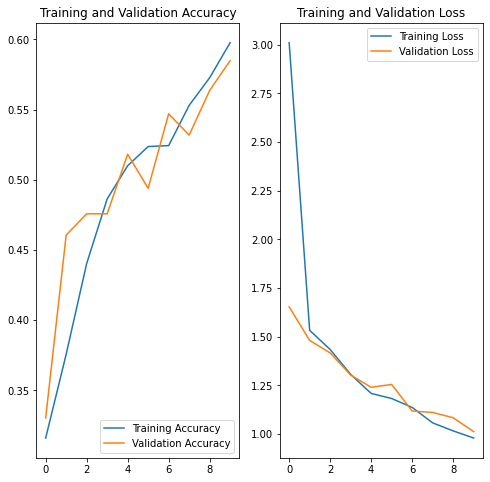

In [ ]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Y_pred = model1.predict_generator(test_ds)
y_pred = np.argmax(Y_pred, axis=1)
import tensorflow as tf
predicted_categories  = y_pred#= np.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
predicted_categories

array([4, 5, 5, 4, 0, 0, 4, 0, 3, 1, 4, 1, 3, 3, 1, 0, 3, 5, 2, 4, 5, 2,
       4, 3, 0, 0, 2, 0, 5, 5, 2, 5, 5, 2, 0, 1, 3, 3, 0, 5, 0, 3, 4, 3,
       3, 0, 0, 3, 4, 1, 2, 5, 2, 1, 0, 3, 5, 2, 4, 4, 3, 5, 2, 5, 0, 3,
       3, 0, 1, 3, 0, 3, 3, 0, 1, 1, 3, 0, 0, 2, 4, 2, 3, 4, 5, 0, 3, 3,
       3, 4, 0, 3, 4, 2, 0, 5, 3, 5, 4, 2, 4, 3, 4, 5, 5, 3, 0, 5, 2, 0,
       3, 0, 5, 1, 5, 5, 1, 1, 1, 3, 0, 4, 5, 4, 2, 4, 3, 3, 2, 3, 3, 5,
       3, 3, 3, 0, 0, 5, 4, 3, 5, 3, 2, 4, 2, 3, 4, 1, 5, 3, 3, 4, 3, 3,
       0, 3, 1, 0, 4, 4, 4, 3, 5, 0, 1, 5, 1, 3, 4, 2, 0, 4, 0, 2, 0, 5,
       0, 4, 3, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

predicted_categories
true_categories = tf.concat([y for x, y in test_ds], axis=0)

classification_report = classification_report(predicted_categories, true_categories)
wandb.log({'classification_report': classification_report})
print(classification_report)

wandb.finish()

              precision    recall  f1-score   support

           0       0.40      0.34      0.37        35
           1       0.53      0.89      0.67        18
           2       0.40      0.60      0.48        20
           3       0.93      0.60      0.73        47
           4       0.90      0.90      0.90        30
           5       0.37      0.37      0.37        30

    accuracy                           0.59       180
   macro avg       0.59      0.62      0.58       180
weighted avg       0.63      0.59      0.59       180



classification_report,precis...


In [ ]:
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

confusion_matrix = confusion_matrix(predicted_categories, true_categories)
wandb.log({'confusion_matrix': confusion_matrix})
print(confusion_matrix)
wandb.finish()

[[12  6 13  0  1  3]
 [ 1 16  0  0  0  1]
 [ 4  2 12  0  0  2]
 [ 4  1  1 28  0 13]
 [ 1  2  0  0 27  0]
 [ 8  3  4  2  2 11]]


In [ ]:
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')
history = model1.evaluate(test_ds, callbacks=[WandbCallback()])

wandb.log({'history' :history})

wandb.finish()

6/6 [==============================] - 1s 164ms/step - loss: 1.1400 - acc: 0.5889


In [ ]:
# test_ds = test_ds.class_names
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

predictions = model1.predict(x=test_ds, steps=len(test_ds), verbose=0, callbacks=[WandbCallback()])
wandb.log({'predictions' :predictions})

wandb.finish()


In [ ]:
# Saving the model
import tensorflow as tf
from keras.models import load_model
model1.save('Inception_V3_Epoch_10')

INFO:tensorflow:Assets written to: Inception_V3_Epoch_10/assets


### Using softmax alone

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model2 = Model(inputs=base_model.input, outputs=predictions)

#freezing of the layers.
for layer in base_model.layers:
    layer.trainable = False

#Initialize wandb with your project name
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 10,
                     "batch_size": 32,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "InceptionV3",
                     "dataset": "maize_diseases_images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model2.compile(optimizer, config.loss_function, metrics=['acc'])

history = model2.fit(train_ds,
                    #val_ds,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    validation_data=(val_ds),
                    # Use the WandbCallback to automatically save all the metrics tracked in model.fit() to your dashboard
                    callbacks=[WandbCallback()])

# Add in a Jupyter notebook to indicate the run has finished
wandb.finish()

Epoch 1/10
94/94 [==============================] - 25s 209ms/step - loss: 17.7669 - acc: 0.4410 - val_loss: 2.0857 - val_acc: 0.5576
Epoch 2/10
94/94 [==============================] - 18s 192ms/step - loss: 2.7693 - acc: 0.5583 - val_loss: 1.8780 - val_acc: 0.5727
Epoch 3/10
94/94 [==============================] - 18s 190ms/step - loss: 1.5089 - acc: 0.6103 - val_loss: 2.2464 - val_acc: 0.5000
Epoch 4/10
94/94 [==============================] - 18s 190ms/step - loss: 1.4288 - acc: 0.6277 - val_loss: 1.8956 - val_acc: 0.5515
Epoch 5/10
94/94 [==============================] - 18s 190ms/step - loss: 1.2735 - acc: 0.6447 - val_loss: 1.1429 - val_acc: 0.6485
Epoch 6/10
94/94 [==============================] - 18s 189ms/step - loss: 0.9336 - acc: 0.6873 - val_loss: 1.1162 - val_acc: 0.6288
Epoch 7/10
94/94 [==============================] - 18s 189ms/step - loss: 0.8374 - acc: 0.7040 - val_loss: 1.1026 - val_acc: 0.6303
Epoch 8/10
94/94 [==============================] - 18s 190ms/step -

acc,0.74267
best_epoch,9
best_val_loss,0.87741
epoch,9
loss,0.7338
val_acc,0.6697
val_loss,0.87741


acc,▁▄▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
val_acc,▃▄▁▃▇▆▆▆██
val_loss,▇▆█▆▂▂▂▂▁▁


In [ ]:
# Saving the model
import tensorflow as tf
from keras.models import load_model
model2.save('Inception_V3_1024')
model2.save('Inception_V3_1024.h5')
model2.save('Inception_V3_1024.js')

INFO:tensorflow:Assets written to: Inception_V3_1024/assets
INFO:tensorflow:Assets written to: Inception_V3_1024.js/assets


In [ ]:
await model.save('Inception_V3_1024:///Downloads');

In [ ]:
import os

In [ ]:
wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')
wandb.save('Inception_V3_1024.h5')
model2.save_weights('Inception_V3_1024.h5')
model2.save(os.path.join(wandb.run.dir, "Inception_V3_1024.h5"))
wandb.finish()

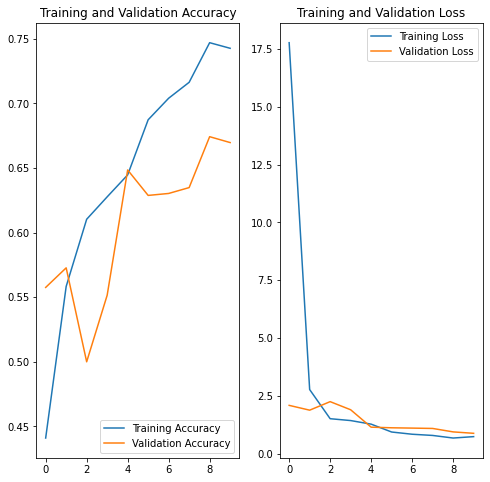

In [ ]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Y_pred = model2.predict_generator(test_ds)
y_pred = np.argmax(Y_pred, axis=1)
import tensorflow as tf
predicted_categories  = y_pred#= np.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

predicted_categories
true_categories = tf.concat([y for x, y in test_ds], axis=0)

classification_report = classification_report(predicted_categories, true_categories)
wandb.log({'classification_report': classification_report})
print(classification_report)

wandb.finish()

              precision    recall  f1-score   support

           0       0.63      0.50      0.56        38
           1       0.60      0.69      0.64        26
           2       0.63      0.66      0.64        29
           3       0.70      0.75      0.72        28
           4       0.93      0.93      0.93        30
           5       0.57      0.59      0.58        29

    accuracy                           0.68       180
   macro avg       0.68      0.69      0.68       180
weighted avg       0.68      0.68      0.68       180



classification_report,precis...


In [ ]:
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

confusion_matrix = confusion_matrix(predicted_categories, true_categories)
wandb.log({'confusion_matrix': confusion_matrix})
print(confusion_matrix)
wandb.finish()

[[19  5  8  1  1  4]
 [ 4 18  1  0  0  3]
 [ 4  2 19  0  0  4]
 [ 2  2  1 21  0  2]
 [ 0  2  0  0 28  0]
 [ 1  1  1  8  1 17]]


In [ ]:
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')
history = model2.evaluate(test_ds, callbacks=[WandbCallback()])

wandb.log({'history' :history})

wandb.finish()

6/6 [==============================] - 1s 161ms/step - loss: 1.0369 - acc: 0.6778


In [ ]:
# test_ds = test_ds.class_names
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

predictions = model2.predict(x=test_ds, steps=len(test_ds), verbose=0, callbacks=[WandbCallback()])
wandb.log({'predictions' :predictions})

wandb.finish()


### Reduce the learning rate from 0.001 to 0.0001

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#freezing of the layers.
for layer in base_model.layers:
    layer.trainable = False

#Initialize wandb with your project name
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 10,
                     "batch_size": 32,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "InceptionV3",
                     "dataset": "maize_diseases_images"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

history = model.fit(train_ds,
                    #val_ds,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    validation_data=(val_ds),
                    # Use the WandbCallback to automatically save all the metrics tracked in model.fit() to your dashboard
                    callbacks=[WandbCallback()])

# Add in a Jupyter notebook to indicate the run has finished
wandb.finish()

Epoch 1/10
94/94 [==============================] - 386s 4s/step - loss: 6.2369 - acc: 0.3080 - val_loss: 3.3730 - val_acc: 0.3924
Epoch 2/10
94/94 [==============================] - 380s 4s/step - loss: 2.7734 - acc: 0.4153 - val_loss: 2.6549 - val_acc: 0.4515
Epoch 3/10
94/94 [==============================] - 377s 4s/step - loss: 2.1503 - acc: 0.4700 - val_loss: 2.1338 - val_acc: 0.4682
Epoch 4/10
94/94 [==============================] - 379s 4s/step - loss: 1.8235 - acc: 0.5043 - val_loss: 2.0100 - val_acc: 0.4697
Epoch 5/10
94/94 [==============================] - 378s 4s/step - loss: 1.6547 - acc: 0.5167 - val_loss: 1.8287 - val_acc: 0.5015
Epoch 6/10
94/94 [==============================] - 378s 4s/step - loss: 1.5094 - acc: 0.5383 - val_loss: 1.8827 - val_acc: 0.4909
Epoch 7/10
94/94 [==============================] - 378s 4s/step - loss: 1.4872 - acc: 0.5493 - val_loss: 1.8173 - val_acc: 0.4955
Epoch 8/10
94/94 [==============================] - 378s 4s/step - loss: 1.3496 - a

acc,0.59067
best_epoch,9
best_val_loss,1.52756
epoch,9
loss,1.21522
val_acc,0.52576
val_loss,1.52756


acc,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▅▅▇▆▆▆██
val_loss,█▅▃▃▂▂▂▁▁▁


In [ ]:
# Saving the model
import tensorflow as tf
from keras.models import load_model
model.save('Inception_V3_LR_0001')

INFO:tensorflow:Assets written to: Inception_V3_LR_0001/assets


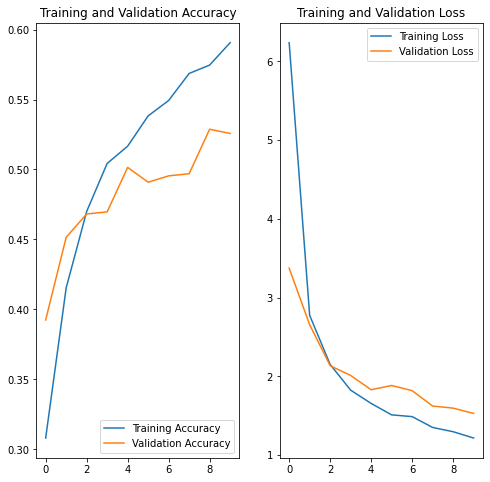

In [ ]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Y_pred = model.predict_generator(test_ds)
y_pred = np.argmax(Y_pred, axis=1)
import tensorflow as tf
predicted_categories  = y_pred#= np.argmax(y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

predicted_categories
true_categories = tf.concat([y for x, y in test_ds], axis=0)

classification_report = classification_report(predicted_categories, true_categories)
wandb.log({'classification_report': classification_report})
print(classification_report)

wandb.finish()

              precision    recall  f1-score   support

           0       0.37      0.24      0.29        45
           1       0.47      0.61      0.53        23
           2       0.33      0.36      0.34        28
           3       0.80      0.65      0.72        37
           4       0.73      0.76      0.75        29
           5       0.33      0.56      0.42        18

    accuracy                           0.51       180
   macro avg       0.51      0.53      0.51       180
weighted avg       0.52      0.51      0.50       180



classification_report,precis...


In [ ]:
run = wandb.init(project='maize_disease_classification',save_code=True,name='inceptionV3')

confusion_matrix = confusion_matrix(predicted_categories, true_categories)
wandb.log({'confusion_matrix': confusion_matrix})
print(confusion_matrix)
wandb.finish()

[[11  8 13  2  6  5]
 [ 1 14  3  1  1  3]
 [ 9  4 10  1  0  4]
 [ 3  2  1 24  0  7]
 [ 2  2  2  0 22  1]
 [ 4  0  1  2  1 10]]


In [ ]:
# Install the scikit plot
!pip install scikit-plot -qqq

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [ ]:
# Log F1 Score
y_test_pred = np.asarray(model.predict(test_ds))
y_test_pred_class = np.argmax(y_test_pred, axis=1)
f1 = f1_score(train_ds, y_test_pred_class, average='micro')
wandb.log({"f1": f1})

# Log Confusion Matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(train_ds, y_test_pred_class, ax=ax)
wandb.log({"confusion_matrix": wandb.Image(fig)})

# Log ROC Curve
fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(train_ds, y_test_pred, ax=ax)
wandb.log({"plot_roc": wandb.Image(fig)})

class_score_data = []
for test, pred in zip(train_ds, y_test_pred):
  class_score_data.append([test, pred])
class_scores_table = wandb.Table(data=class_score_data, columns=["test", "pred"])
wandb.log({"class_scores": class_scores_table})

ValueError: ignored

In [ ]:
import os

In [ ]:
wandb.init()
wandb.save('Inception_V3_LR_01.h5')
model.save_weights('Inception_V3_LR_01.h5')
model.save(os.path.join(wandb.run.dir, "Inception_V3_LR_01.h5"))

In [ ]:
# model = tf.keras.applications.inception_v3.InceptionV3(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000,
#     classifier_activation='softmax'
# )

In [ ]:
# Initialize model like you usually do.
#tf.keras.backend.clear_session()
#model = Model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

### Changing the batch size from 1024 to 32

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(32, activation='relu')(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#freezing of the layers.
for layer in base_model.layers:
    layer.trainable = False

# Initialize wandb with your project name
run = wandb.init(project='maize_desease_classification',save_code=True,name='augmented classes',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.01,
                     "epochs": 10,
                     "batch_size": 32,
                     "loss_function": "'sparse_categorical_crossentropy'",
                     "architecture": "Inception_V3",
                     "dataset": "maize_images",
                     "metrics": 'accuracy',
                 })

config = wandb.config  # We'll use this to configure our experiment

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['accuracy'])

# import wandcallback 
#from wandb.keras import WandbCallback

# We train with our model.fit
# WandbCallback is used as a regular callback
# We again use config
history= model.fit(train_ds,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(val_ds))
          #callbacks=[WandbCallback()])

run.finish()

Epoch 1/10


ValueError: ignored

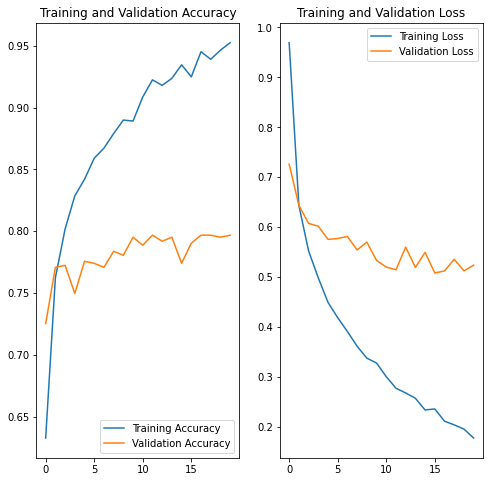

In [ ]:
# Creating plots of loss and accuracy on the training and validation sets.
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config.epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()